### Импортируем библиотеки

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns 
import matplotlib

In [9]:
#настройка, чтобы можно было просматривать все столбцы датафрейма
matplotlib.rcParams.update({'font.size': 14})
pd.options.display.max_columns = 100

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

### Загружаем данные

In [11]:
# для работы
adres_data = 'C:/Users/lazarevnv/OneDrive/1_Обучение/ML_проекты/IEK_test/test.xlsx'

In [ ]:
# для дома
# adres_data = 'C:/Users/Ник/OneDrive/1_Обучение/ML_проекты/IEK_test/test.xlsx'

In [12]:
df =  pd.ExcelFile(adres_data)

In [13]:
print(df.sheet_names)

['train', 'Черновик', 'test', 'test (2)']


In [15]:
df_test = df.parse('test')

In [16]:
df_train = df_train.set_index('Date')

In [17]:
#  посмотрим датафрейм последние 3 строки
df_train.head(3)

,Y
Date,
2015-03-01,3022.1
2015-04-01,2474.7
2015-05-01,2405.6


In [21]:
# подготовим датафрейм с нужным полем вместо индекса
df_test = df_test.set_index('Date').head(6).copy()

In [22]:
#  посмотрим датафрейм
df_test

""
Date
2018-11-01
2018-12-01
2019-01-01
2019-02-01
2019-03-01
2019-04-01


In [23]:
# посмотрим размеры загруженного датафрейма
df_train.shape

(44, 1)

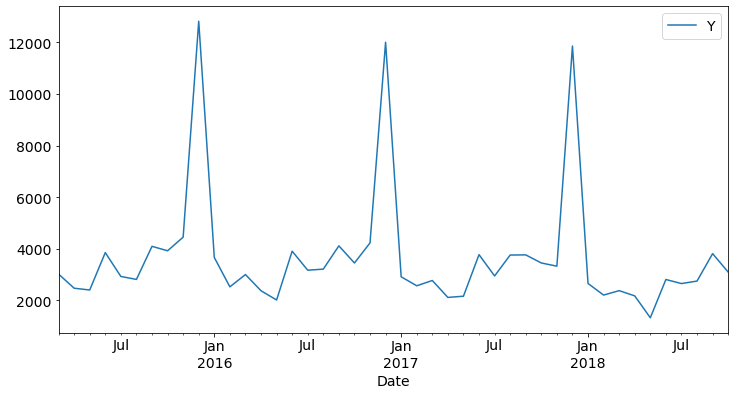

In [197]:
# визуализируем загруженные данные
df_train.plot(figsize = (12, 6))
plt.show()

In [25]:
# посмотрим дополнительную информацию 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2015-03-01 to 2018-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       44 non-null     float64
dtypes: float64(1)
memory usage: 704.0 bytes


### Экспоненциальное сглаживание

Обоснование. В качестве метода прогнозирования было выбрано экспоненциальное сглаживание. Т.к. данный метод широко используется для анализа одномерных временных рядов.

В модели заданы следующие параметры:
- период сезонности 12 количество месяцев в году (seasonal_periods = 12)
- необходимость учета тренда (trend='add')
- необходимость учёта сезонности (seasonal='add')

In [26]:
# экспортируем необходимый модуль
from statsmodels.tsa.api import ExponentialSmoothing

In [27]:
# задаётся модель
model_ES = ExponentialSmoothing(np.asarray(df_train),
                            seasonal_periods = 12,
                            trend='add', 
                            seasonal='add').fit()

C:\Users\lazarevnv\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [186]:
# прогнозные значения по методу экспоненциального сглаживания на период 6 мес.
prognos_ES = model_ES.forecast(6)
prognos_ES

array([ 3239.34122881, 11596.19880626,  2445.70525741,  1935.72987469,
        2152.75442842,  1785.62233336])

In [29]:
# вносим прогноз в датафрейм df_test
df_test['Y'] = prognos_ES

In [30]:
df_test

,Y
Date,
2018-11-01,3239.341229
2018-12-01,11596.198806
2019-01-01,2445.705257
2019-02-01,1935.729875
2019-03-01,2152.754428
2019-04-01,1785.622333


### Визуализация

In [31]:
def grafics(y_train, y_test_pred):
    '''метод вызуализации фактических и прогнозных значений'''
    plt.figure(figsize = (18, 5))
    plt.plot(y_train, label = 'факт')
    plt.plot(y_test_pred, label = 'прогноз')
    plt.legend(loc = 'best')
    plt.show()
    return



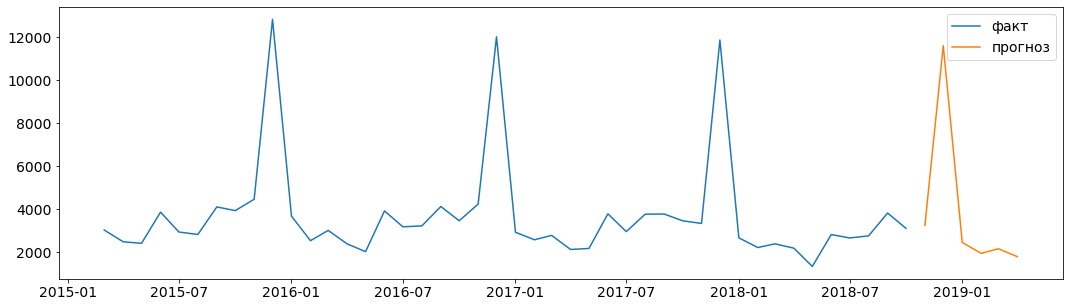

In [33]:
# визуализируем фактические и прогнозные значения
grafics(df_train, df_test)

### Доверительный интервал

In [40]:
# импортируем библиотеку scipy.stats
import scipy.stats as st

In [38]:
# подготовим общий датафрейм для оценки доверительного интервала
df_result = pd.concat([df_train, df_test], axis = 0)

In [195]:
# рассчитаем общий доверительный интервал для всей последовательности значений
st.t.interval(0.95, len(df_result['Y'])-1, loc=np.mean(df_result['Y']), scale=st.sem(df_result['Y']))

(2961.9458019724366, 4436.816275185391)

Построен доверительный интервал (с уровнем доверия 95%) для всей последовательности значений (генеральной совокупности), далее построим доверительный интервал для выборки по каждому месяцу в отдельности.

In [45]:
# создадим дополнительное поле 'Month' для группировки
df_result['Month'] = pd.DatetimeIndex(df_result.index).month

In [46]:
df_result.head(3)

,Y,Month
Date,,
2015-03-01,3022.1,3
2015-04-01,2474.7,4
2015-05-01,2405.6,5


In [76]:
def interval(df):
    '''метод расчета доверительного интервала'''
    st_interval = st.t.interval(0.95, len(df) -1, loc=np.mean(df.Y), scale=st.sem(df.Y))
    return st_interval

In [ ]:
# создаём поле для дальнейшего сохранения значений доверительного интервала
df_result['interval'] = 0

In [177]:
# запускаем цикл расчета доверительного интервала
# для последовательности значени каждого месяца
for month in df_result['Month'].unique():
    df = df_result.loc[df_result['Month'] == month]
    st_interval = interval(df)
    # сохраняем значения доверительного интервала в поле 'interval'
    df_result.loc[df_result['Month'] == month, 'interval'] = str(st_interval)

In [181]:
df_result_ = df_result.tail(6).copy()
df_result_

,Y,Month,interval
Date,,,
2018-11-01,3239.341229,11,"(2828.684249157154, 4797.586365247935)"
2018-12-01,11596.198806,12,"(11231.248455687119, 12909.900947440705)"
2019-01-01,2445.705257,1,"(2074.886142261932, 3769.0664864426326)"
2019-02-01,1935.729875,2,"(1837.4296464382232, 2783.085290906438)"
2019-03-01,2152.754428,3,"(2186.664498774163, 3146.477272593963)"
2019-04-01,1785.622333,4,"(1855.0209302350581, 2517.5080031093817)"


### Выгрузка данных

In [182]:
# подготовим датафрейм для выгрузки, удалим ненужное поле Month
df_result_.drop('Month', axis = 1, inplace = True)

In [183]:
df_result_

,Y,interval
Date,,
2018-11-01,3239.341229,"(2828.684249157154, 4797.586365247935)"
2018-12-01,11596.198806,"(11231.248455687119, 12909.900947440705)"
2019-01-01,2445.705257,"(2074.886142261932, 3769.0664864426326)"
2019-02-01,1935.729875,"(1837.4296464382232, 2783.085290906438)"
2019-03-01,2152.754428,"(2186.664498774163, 3146.477272593963)"
2019-04-01,1785.622333,"(1855.0209302350581, 2517.5080031093817)"


In [185]:
df_result_.to_excel(r'C:/Users/lazarevnv/OneDrive/1_Обучение/ML_проекты/IEK_test/test_result.xlsx', index = True)